In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


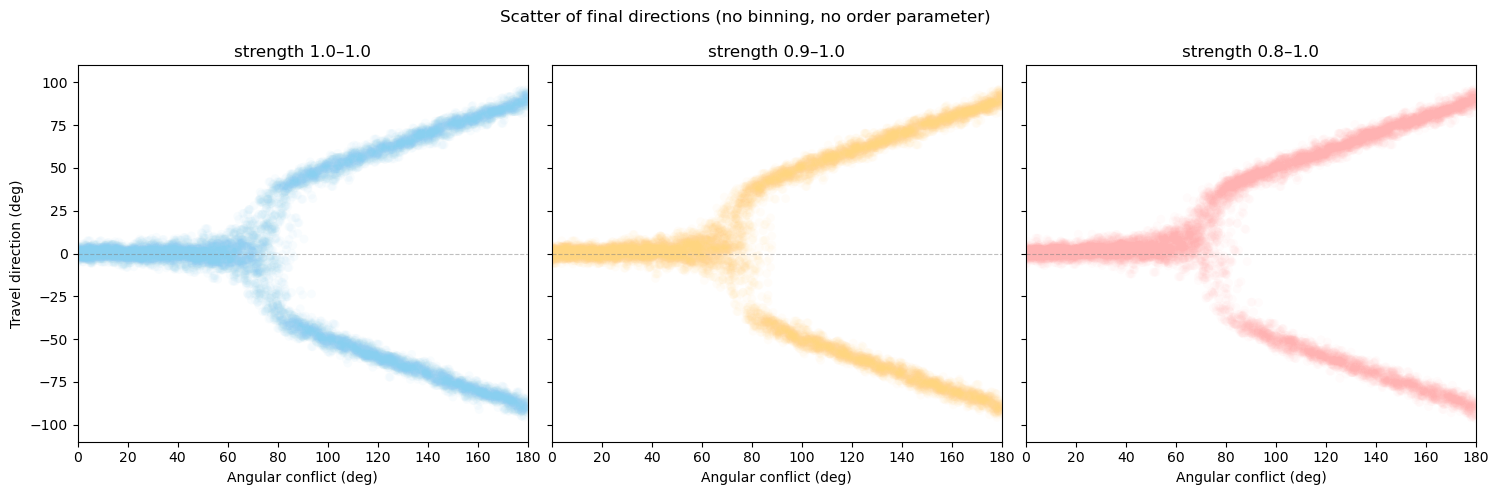

In [21]:
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun"
}
h5_name = "experiment.h5"

style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2"},
    "strength 1.0–1.0": {"pt": "#89CFF0"},
    "strength 0.9–1.0": {"pt": "#FFD580"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Scatter plots (no binning, no order parameter) ----------
n_exp = len(sim_data)
fig, axes = plt.subplots(1, n_exp, figsize=(5*n_exp, 5), sharey=True)

if n_exp == 1:
    axes = [axes]

for ax, (name, dct) in zip(axes, sim_data.items()):
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        angles_all.extend([a] * len(vals))
        dirs_all.extend(vals)

    ax.scatter(angles_all, dirs_all, s=40, alpha=0.05,
               color=style[name]["pt"], edgecolors="none")
    
    ax.axhline(0, color="grey", lw=0.8, ls="--", alpha=0.5)
    ax.set_title(name)
    ax.set_xlabel("Angular conflict (deg)")
    ax.set_xlim(0, 180)

axes[0].set_ylabel("Travel direction (deg)")
axes[0].set_ylim(-110, 110)

fig.suptitle("Scatter of final directions (no binning, no order parameter)")
fig.tight_layout()
plt.show()


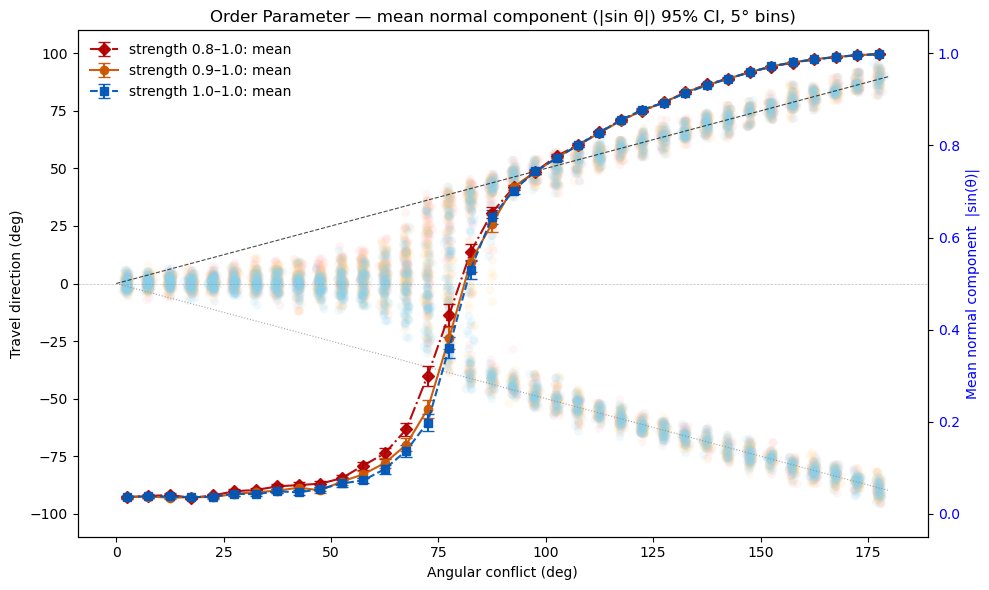

In [12]:
# --- COMPARISON PLOT: Simulations (10° bins only)
# --- Order parameter: mean/median/mode of |sin(direction)| with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 5      # bin width for simulations
snap_tol_deg = 0.75    # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "mean"  # choose: "mean", "median", or "mode"
N_BOOT = 1000          # bootstrap samples for CI

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees (returns in [0,1])."""
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def _mode_hist(x, bins="fd"):
    """Histogram-mode estimator: return bin center of the highest-density bin (range [0,1])."""
    x = np.asarray(x, float)
    if isinstance(bins, str) and bins == "fd":
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        bins = max(5, int(np.ceil((x.max() - x.min()) / h))) if h > 0 else 10
    counts, edges = np.histogram(x, bins=bins, range=(0.0, 1.0))
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0):
    """
    Return (estimate, ci_halfwidth) for stat in {'mean','median','mode'} using bootstrap 95% CI.
    - mean: bootstrap mean
    - median: bootstrap median
    - mode: histogram mode via _mode_hist, bootstrapped
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    rng = np.random.default_rng(rng_seed)

    if stat == "mean":
        est = float(np.mean(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.mean(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "median":
        est = float(np.median(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.median(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "mode":
        est = float(_mode_hist(x))
        if n < 3:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = _mode_hist(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    else:
        raise ValueError("stat must be 'mean', 'median', or 'mode'")

    ci_half = 0.5 * (hi - lo)
    return est, float(ci_half)

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}  # name -> dict(angle->list[dir_deg])
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Shared binning over the combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Per-simulation order stat in bins ----------
def binned_order_stat(angles_to_dirs, stat, n_boot, seed):
    stats, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            stats.append(np.nan); cis.append(np.nan); continue
        nc = normal_component_magnitude_deg(np.array(bin_dirs, dtype=float))
        est, ci = order_stat_with_ci(nc, stat=stat, n_boot=n_boot, rng_seed=seed)
        stats.append(est); cis.append(ci)
    return np.array(stats, float), np.array(cis, float)

binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_order_stat(dct, ORDER_STAT, N_BOOT, seed=456 + i)

# ---------- Prepare snapped scatter for raw directions ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped_scatter = {}  # name -> (angles_snapped, dirs)
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        nearest_bin = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nearest_bin - a) <= snap_tol_deg:
            angles_all.extend([nearest_bin] * len(vals))
            dirs_all.extend(vals)
    snapped_scatter[name] = (np.array(angles_all, float), np.array(dirs_all, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: order-stat curves with 95% CI
ax2 = ax1.twinx()
label_name = ORDER_STAT  # "mean" | "median" | "mode"
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: {label_name}'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} normal component  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Order Parameter — {label_name} normal component (|sin θ|) 95% CI, {angle_bin_deg}° bins)')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


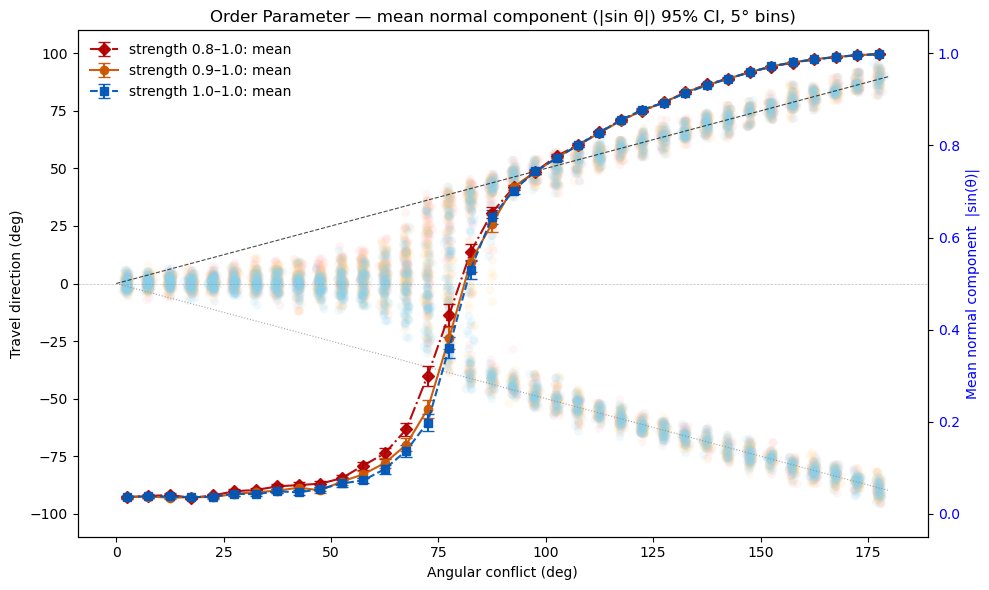

In [13]:
# --- COMPARISON PLOT: Simulations (10° bins only)
# --- Order parameter: mean/median/mode of |sin(direction)| with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 5      # bin width for simulations
snap_tol_deg = 0.75    # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "mean"  # choose: "mean", "median", or "mode"
N_BOOT = 1000          # bootstrap samples for CI

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees (returns in [0,1])."""
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def _mode_hist(x, bins="fd"):
    """Histogram-mode estimator: return bin center of the highest-density bin (range [0,1])."""
    x = np.asarray(x, float)
    if isinstance(bins, str) and bins == "fd":
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        bins = max(5, int(np.ceil((x.max() - x.min()) / h))) if h > 0 else 10
    counts, edges = np.histogram(x, bins=bins, range=(0.0, 1.0))
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0):
    """
    Return (estimate, ci_halfwidth) for stat in {'mean','median','mode'} using bootstrap 95% CI.
    - mean: bootstrap mean
    - median: bootstrap median
    - mode: histogram mode via _mode_hist, bootstrapped
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    rng = np.random.default_rng(rng_seed)

    if stat == "mean":
        est = float(np.mean(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.mean(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "median":
        est = float(np.median(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.median(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "mode":
        est = float(_mode_hist(x))
        if n < 3:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = _mode_hist(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    else:
        raise ValueError("stat must be 'mean', 'median', or 'mode'")

    ci_half = 0.5 * (hi - lo)
    return est, float(ci_half)

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}  # name -> dict(angle->list[dir_deg])
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Shared binning over the combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Per-simulation order stat in bins ----------
def binned_order_stat(angles_to_dirs, stat, n_boot, seed):
    stats, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            stats.append(np.nan); cis.append(np.nan); continue
        nc = normal_component_magnitude_deg(np.array(bin_dirs, dtype=float))
        est, ci = order_stat_with_ci(nc, stat=stat, n_boot=n_boot, rng_seed=seed)
        stats.append(est); cis.append(ci)
    return np.array(stats, float), np.array(cis, float)

binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_order_stat(dct, ORDER_STAT, N_BOOT, seed=456 + i)

# ---------- Prepare snapped scatter for raw directions ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped_scatter = {}  # name -> (angles_snapped, dirs)
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        nearest_bin = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nearest_bin - a) <= snap_tol_deg:
            angles_all.extend([nearest_bin] * len(vals))
            dirs_all.extend(vals)
    snapped_scatter[name] = (np.array(angles_all, float), np.array(dirs_all, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: order-stat curves with 95% CI
ax2 = ax1.twinx()
label_name = ORDER_STAT  # "mean" | "median" | "mode"
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: {label_name}'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} normal component  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Order Parameter — {label_name} normal component (|sin θ|) 95% CI, {angle_bin_deg}° bins)')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


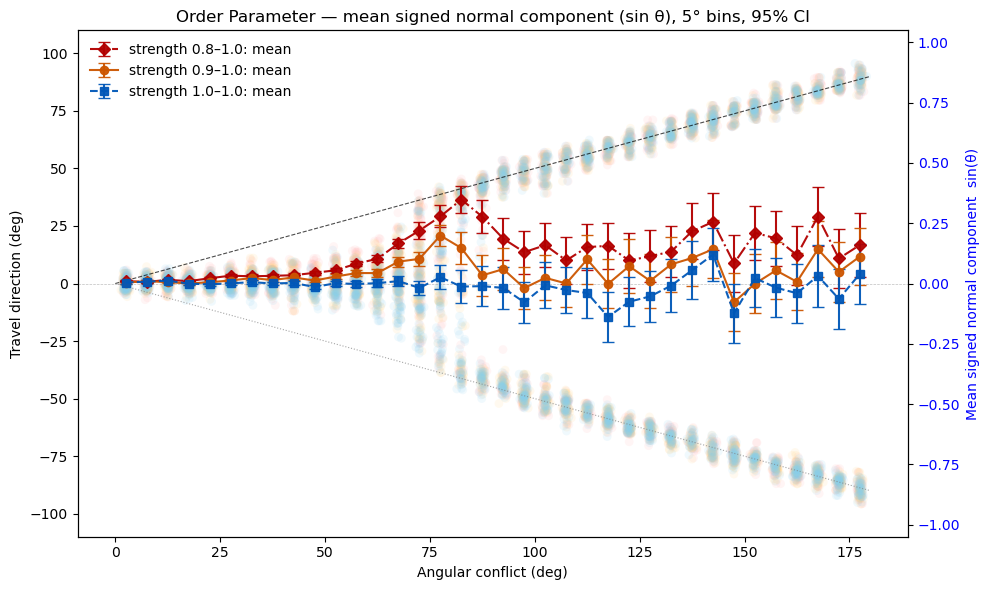

In [14]:
# --- COMPARISON PLOT: Simulations (10° bins only)
# --- Order parameter: mean/median/mode of sin(direction) with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 5      # bin width for simulations
snap_tol_deg = 0.75    # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "mean"    # choose: "mean", "median", or "mode"
N_BOOT = 1000          # bootstrap samples for CI

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_signed_deg(direction_deg_array):
    """Compute signed sin(theta) where theta is in degrees (range [-1, 1])."""
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.sin(theta_rad)

def _mode_hist(x, bins="fd", value_range=(-1.0, 1.0)):
    """Histogram-mode estimator over a fixed range (default [-1,1]). Returns bin center."""
    x = np.asarray(x, float)
    if isinstance(bins, str) and bins == "fd":
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        # Ensure a reasonable number of bins within the fixed range
        total_width = value_range[1] - value_range[0]
        bins = max(5, int(np.ceil(total_width / h))) if h > 0 else 10
    counts, edges = np.histogram(x, bins=bins, range=value_range)
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0, mode_range=(-1.0, 1.0)):
    """
    Return (estimate, ci_halfwidth) for stat in {'mean','median','mode'} using bootstrap 95% CI.
    For 'mode', uses histogram mode over the provided mode_range (default [-1,1]).
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    rng = np.random.default_rng(rng_seed)

    if stat == "mean":
        est = float(np.mean(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.mean(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "median":
        est = float(np.median(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.median(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "mode":
        est = float(_mode_hist(x, value_range=mode_range))
        if n < 3:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = _mode_hist(sample, value_range=mode_range)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    else:
        raise ValueError("stat must be 'mean', 'median', or 'mode'")

    ci_half = 0.5 * (hi - lo)
    return est, float(ci_half)

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}  # name -> dict(angle->list[dir_deg])
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Shared binning over the combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Per-simulation order stat in bins (SIGNED sin) ----------
def binned_order_stat(angles_to_dirs, stat, n_boot, seed):
    stats, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            stats.append(np.nan); cis.append(np.nan); continue
        nc = normal_component_signed_deg(np.array(bin_dirs, dtype=float))
        est, ci = order_stat_with_ci(nc, stat=stat, n_boot=n_boot, rng_seed=seed, mode_range=(-1.0, 1.0))
        stats.append(est); cis.append(ci)
    return np.array(stats, float), np.array(cis, float)

binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_order_stat(dct, ORDER_STAT, N_BOOT, seed=456 + i)

# ---------- Prepare snapped scatter for raw directions ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped_scatter = {}  # name -> (angles_snapped, dirs)
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        nearest_bin = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nearest_bin - a) <= snap_tol_deg:
            angles_all.extend([nearest_bin] * len(vals))
            dirs_all.extend(vals)
    snapped_scatter[name] = (np.array(angles_all, float), np.array(dirs_all, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: order-stat curves with 95% CI (SIGNED sin)
ax2 = ax1.twinx()
label_name = ORDER_STAT  # "mean" | "median" | "mode"
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: {label_name}'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} signed normal component  sin(θ)', color='blue')
ax2.set_ylim(-1.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Order Parameter — {label_name} signed normal component (sin θ), {angle_bin_deg}° bins, 95% CI')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


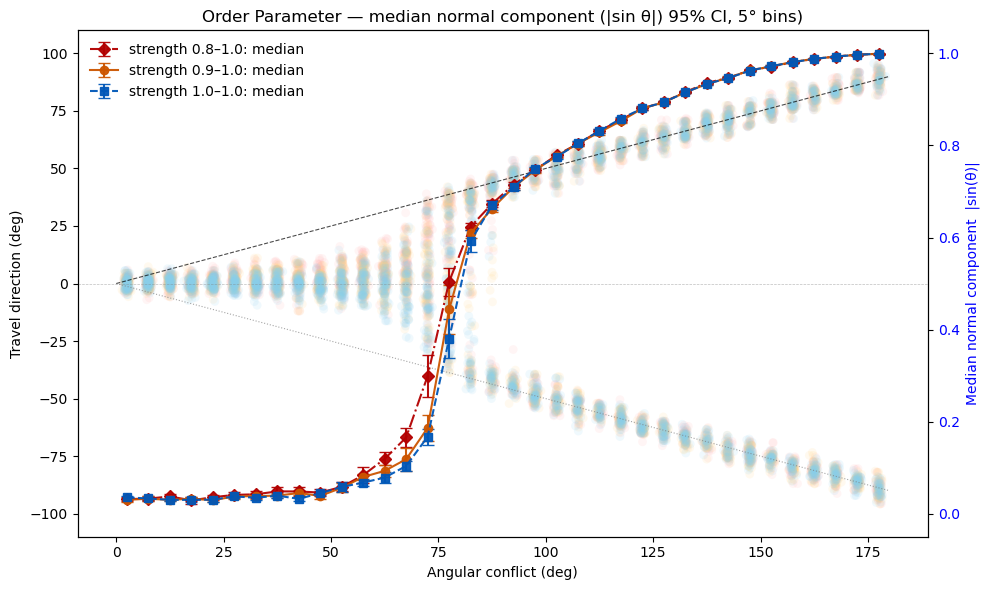

In [15]:
# --- COMPARISON PLOT: Simulations (10° bins only)
# --- Order parameter: mean/median/mode of |sin(direction)| with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 5      # bin width for simulations
snap_tol_deg = 0.75    # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "median"  # choose: "mean", "median", or "mode"
N_BOOT = 1000          # bootstrap samples for CI

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees (returns in [0,1])."""
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def _mode_hist(x, bins="fd"):
    """Histogram-mode estimator: return bin center of the highest-density bin (range [0,1])."""
    x = np.asarray(x, float)
    if isinstance(bins, str) and bins == "fd":
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        bins = max(5, int(np.ceil((x.max() - x.min()) / h))) if h > 0 else 10
    counts, edges = np.histogram(x, bins=bins, range=(0.0, 1.0))
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0):
    """
    Return (estimate, ci_halfwidth) for stat in {'mean','median','mode'} using bootstrap 95% CI.
    - mean: bootstrap mean
    - median: bootstrap median
    - mode: histogram mode via _mode_hist, bootstrapped
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    rng = np.random.default_rng(rng_seed)

    if stat == "mean":
        est = float(np.mean(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.mean(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "median":
        est = float(np.median(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = np.median(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "mode":
        est = float(_mode_hist(x))
        if n < 3:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = _mode_hist(sample)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    else:
        raise ValueError("stat must be 'mean', 'median', or 'mode'")

    ci_half = 0.5 * (hi - lo)
    return est, float(ci_half)

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}  # name -> dict(angle->list[dir_deg])
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Shared binning over the combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Per-simulation order stat in bins ----------
def binned_order_stat(angles_to_dirs, stat, n_boot, seed):
    stats, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            stats.append(np.nan); cis.append(np.nan); continue
        nc = normal_component_magnitude_deg(np.array(bin_dirs, dtype=float))
        est, ci = order_stat_with_ci(nc, stat=stat, n_boot=n_boot, rng_seed=seed)
        stats.append(est); cis.append(ci)
    return np.array(stats, float), np.array(cis, float)

binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_order_stat(dct, ORDER_STAT, N_BOOT, seed=456 + i)

# ---------- Prepare snapped scatter for raw directions ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped_scatter = {}  # name -> (angles_snapped, dirs)
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        nearest_bin = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nearest_bin - a) <= snap_tol_deg:
            angles_all.extend([nearest_bin] * len(vals))
            dirs_all.extend(vals)
    snapped_scatter[name] = (np.array(angles_all, float), np.array(dirs_all, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: order-stat curves with 95% CI
ax2 = ax1.twinx()
label_name = ORDER_STAT  # "mean" | "median" | "mode"
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: {label_name}'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} normal component  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Order Parameter — {label_name} normal component (|sin θ|) 95% CI, {angle_bin_deg}° bins)')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


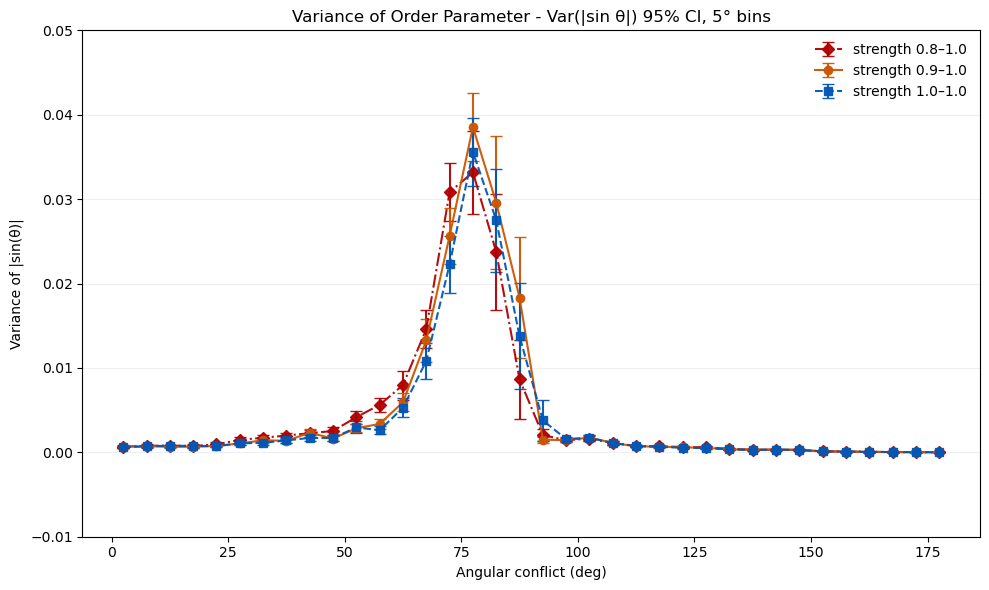

In [16]:
# --- VARIANCE PLOT: |sin(direction)| variance per angle bin, 3 simulations ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 5
N_BOOT = 1000

style = {
    "strength 0.8–1.0": {"ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 0.9–1.0": {"ln": "#CC5500", "marker": "o", "ls": "-"},
    "strength 1.0–1.0": {"ln": "#0057B8", "marker": "s", "ls": "--"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def variance_with_boot_ci(x, n_boot=1000, rng_seed=0):
    """
    Sample variance (ddof=1) and 95% bootstrap CI half-width.
    Returns (var_hat, ci_halfwidth). NaN if fewer than 2 samples.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    var_hat = np.var(x, ddof=1)
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        boots[i] = np.var(sample, ddof=1)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return float(var_hat), float(0.5 * (hi - lo))

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # autodetect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_dir_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_dir_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_dir_deg)
    if not out:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    sim_data[name] = load_simulation_angles(os.path.join(folder, h5_name))

# ---------- Shared binning over combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Compute variance of order parameter per bin ----------
def binned_variance(angles_to_dirs, seed_base=0):
    var_hat, ci = [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, dirs in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            var_hat.append(np.nan); ci.append(np.nan); continue
        nc = normal_component_magnitude_deg(bin_dirs)  # order parameter values in [0,1]
        v, hwidth = variance_with_boot_ci(nc, n_boot=N_BOOT, rng_seed=seed_base + j)
        var_hat.append(v); ci.append(hwidth)
    return np.array(var_hat, float), np.array(ci, float)

binned = {name: binned_variance(dct, seed_base=777 + k*1000)
          for k, (name, dct) in enumerate(sim_data.items())}

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

for name in sim_data.keys():
    y, ci = binned[name]
    ax.errorbar(
        bin_centers, y, yerr=ci,
        fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f"{name}"
    )

ax.set_xlabel("Angular conflict (deg)")
ax.set_ylabel("Variance of |sin(θ)|")
ax.set_ylim(-0.01, 0.05)  # theoretical max is 0.25 for data in [0,1]; a bit of headroom
ax.grid(True, which="both", axis="y", alpha=0.2)
plt.title(f"Variance of Order Parameter - Var(|sin θ|) 95% CI, {angle_bin_deg}° bins")
ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
plt.show()

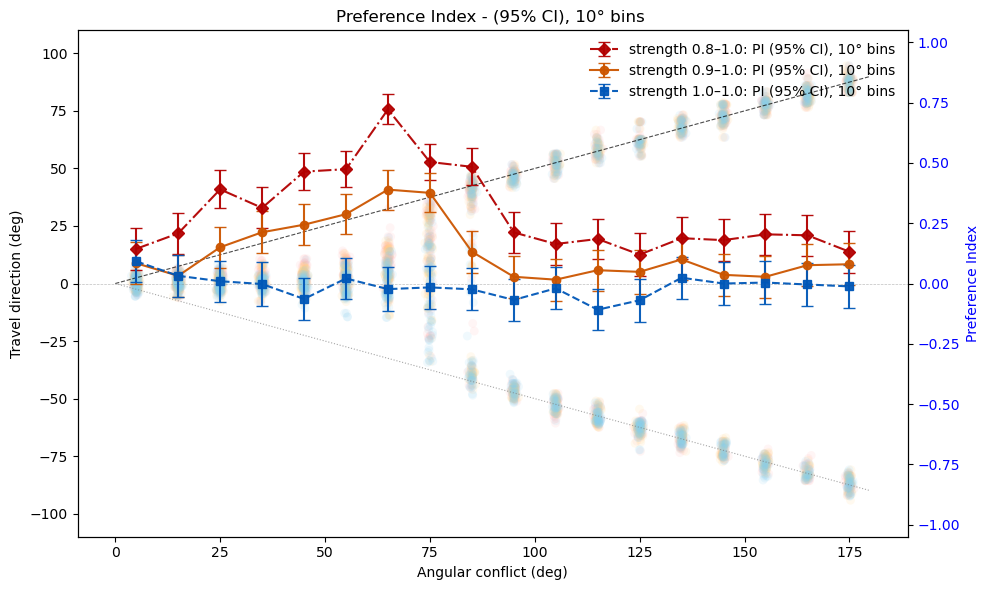

In [17]:
# --- COMPARISON PLOT: Simulations (10° bins) with Preference Index ---
# PI per bin = 2 * (n_pos / (n_pos + n_neg)) - 1, CI via binomial SE
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt
# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun"
}
h5_name = "experiment.h5"

angle_bin_deg = 10   # shared bin width
snap_tol_deg = 0.75  # snapping tolerance for scatter visualization

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def compute_pi(vals):
    """Preference Index and ~95% CI (Wald) from signs of angles (deg). Ignores exact zeros."""
    vals = np.asarray(vals, dtype=float)
    n_pos = np.sum(vals > 0)
    n_neg = np.sum(vals < 0)
    total = n_pos + n_neg
    if total == 0:
        return np.nan, np.nan
    p = n_pos / total
    pi = 2 * p - 1
    # Binomial SE for p, then scaled by factor 2 for PI; 1.96 ~ 95% CI
    se_p = np.sqrt(p * (1 - p) / total)
    ci95 = 1.96 * (2 * se_p)
    return float(pi), float(ci95)

def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def load_sim_angles(h5_path):
    """Load runs -> map angle(deg) -> list of final_direction_deg."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # autodetect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_dir_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_dir_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_dir_deg)
    if not out:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load both simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    sim_data[name] = load_sim_angles(os.path.join(folder, h5_name))

# ---------- Shared binning over combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- PI per sim per bin ----------
def binned_pi(angles_to_dirs):
    pis, ci95s = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_vals = []
        for a, dirs in angles_to_dirs.items():
            if lo <= a < hi:
                bin_vals.extend(dirs)
        pi, ci = compute_pi(bin_vals)
        pis.append(pi); ci95s.append(ci)
    return np.array(pis, float), np.array(ci95s, float)

binned = {name: binned_pi(dct) for name, dct in sim_data.items()}

# ---------- Prepare snapped scatter (raw final directions) ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped = {}
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    xs, ys = [], []
    for a, vals in dct.items():
        nb = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nb - a) <= snap_tol_deg:
            xs.extend([nb] * len(vals))
            ys.extend(vals)
    snapped[name] = (np.array(xs, float), np.array(ys, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw directions per sim
for name in sim_data.keys():
    xs, ys = snapped[name]
    if xs.size:
        ax1.scatter(jitter(xs), ys, s=40, alpha=0.12, color=style[name]["pt"], edgecolors='none')

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: PI curves with 95% CI
ax2 = ax1.twinx()
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci,
        fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: PI (95% CI), {angle_bin_deg}° bins'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel("Preference Index", color='blue')
ax2.set_ylim(-1.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"Preference Index - (95% CI), {angle_bin_deg}° bins ")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


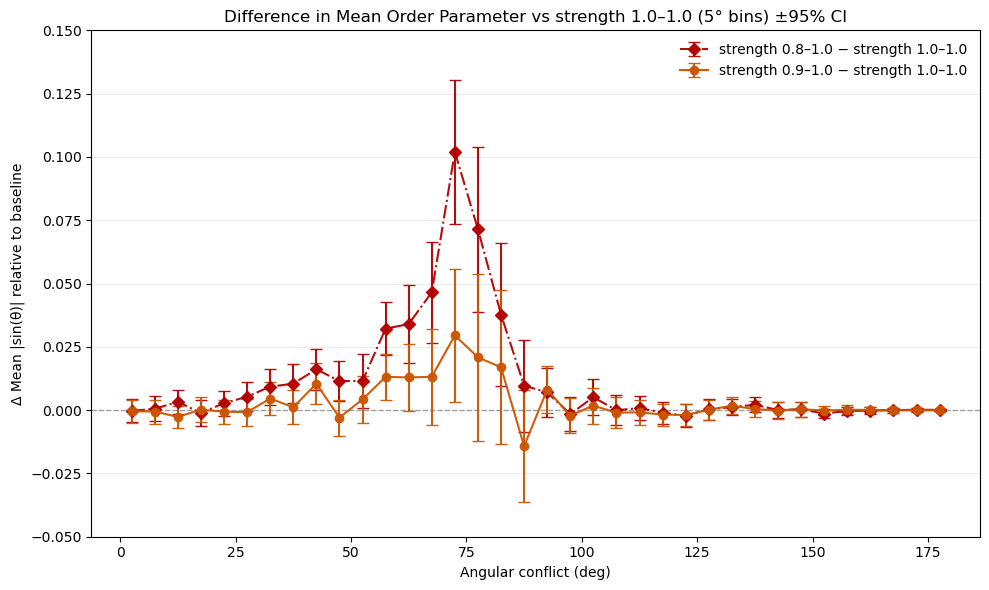

In [18]:
# --- DIFFERENCE PLOT: Mean |sin(direction)| vs baseline "strength 1.0–1.0" ---
# Δ mean per angle bin with 95% bootstrap CI (independent resampling)
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun",  # baseline
}
baseline_name = "strength 1.0–1.0"
h5_name = "experiment.h5"

angle_bin_deg = 5
N_BOOT = 2000  # more reps to stabilize CI for differences

style = {
    "strength 0.8–1.0": {"ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 0.9–1.0": {"ln": "#CC5500", "marker": "o", "ls": "-"},
    "strength 1.0–1.0": {"ln": "#0057B8", "marker": "s", "ls": "--"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # autodetect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_dir_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_dir_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_dir_deg)
    if not out:
        raise ValueError(f"No runs found in {h5_path}")
    return out

def binned_mean(arr):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    return np.nan if arr.size == 0 else float(np.mean(arr))

def bootstrap_mean_diff(x, y, n_boot=2000, seed=0):
    """
    Bootstrap CI for mean(x) - mean(y), resampling each independently (with replacement).
    Returns (diff_estimate, ci_halfwidth). NaN if either empty.
    """
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    y = np.asarray(y, float); y = y[np.isfinite(y)]
    nx, ny = x.size, y.size
    if nx == 0 or ny == 0:
        return np.nan, np.nan
    est = float(np.mean(x) - np.mean(y))
    rng = np.random.default_rng(seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        boots[i] = np.mean(xb) - np.mean(yb)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, float(0.5 * (hi - lo))

# ---------- Load simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    sim_data[name] = load_simulation_angles(os.path.join(folder, h5_name))

# ---------- Shared binning over combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Build per-bin order-parameter arrays for each sim ----------
def per_bin_order_parameter(angles_to_dirs):
    """Return list of arrays (one per bin) of |sin(direction)|."""
    per_bin = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for a, dirs in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(dirs)
        per_bin.append(normal_component_magnitude_deg(bin_dirs))
    return per_bin

perbin_nc = {name: per_bin_order_parameter(dct) for name, dct in sim_data.items()}

# ---------- Compute Δ mean vs baseline for each non-baseline sim ----------
diff_results = {}  # name -> (delta_mean, delta_ci)
baseline_bins = perbin_nc[baseline_name]
for name, bins in perbin_nc.items():
    if name == baseline_name:
        continue
    delta_mean = np.full(len(bin_centers), np.nan, float)
    delta_ci   = np.full(len(bin_centers), np.nan, float)
    for i in range(len(bin_centers)):
        x = bins[i]
        y = baseline_bins[i]
        # If baseline bin is empty, we can't compute a difference
        if y.size == 0:
            continue
        est, hwidth = bootstrap_mean_diff(x, y, n_boot=N_BOOT, seed=1234 + i)
        delta_mean[i] = est
        delta_ci[i] = hwidth
    diff_results[name] = (delta_mean, delta_ci)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

# Zero reference
ax.axhline(0, color='grey', lw=1.0, ls='--', alpha=0.7)

# Plot differences with 95% CI
for name, (dm, ci) in diff_results.items():
    ax.errorbar(
        bin_centers, dm, yerr=ci,
        fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f"{name} − {baseline_name}"
    )

ax.set_xlabel("Angular conflict (deg)")
ax.set_ylabel("Δ Mean |sin(θ)| relative to baseline")
# Set symmetric y-limits around 0 with small margin
finite_vals = np.hstack([v[0][np.isfinite(v[0])] + v[1][np.isfinite(v[1])] * 0 for v in diff_results.values()])  # just to get non-empty
max_abs = 0.0
for dm, _ in diff_results.values():
    if np.any(np.isfinite(dm)):
        max_abs = max(max_abs, np.nanmax(np.abs(dm)))
ylim = max(0.1, min(1.0, max_abs * 1.2))
ax.set_ylim(-ylim, ylim)
ax.set_ylim(-0.05,0.15)

ax.grid(True, which="both", axis="y", alpha=0.25)
plt.title(f"Difference in Mean Order Parameter vs {baseline_name} (5° bins) ±95% CI")
ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


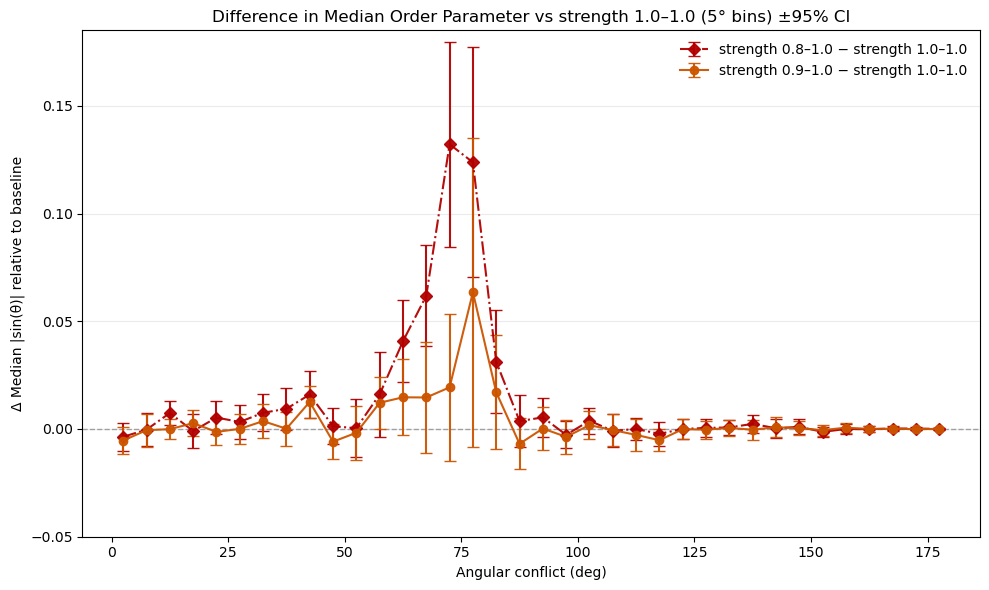

In [19]:
# --- DIFFERENCE PLOT: Median |sin(direction)| vs baseline "strength 1.0–1.0" ---
# Δ median per angle bin with 95% bootstrap CI (independent resampling)
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun",  # baseline
}
baseline_name = "strength 1.0–1.0"
h5_name = "experiment.h5"

angle_bin_deg = 5
N_BOOT = 2000  # plenty for median differences

style = {
    "strength 0.8–1.0": {"ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 0.9–1.0": {"ln": "#CC5500", "marker": "o", "ls": "-"},
    "strength 1.0–1.0": {"ln": "#0057B8", "marker": "s", "ls": "--"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    return np.abs(np.sin(theta_rad))

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # autodetect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_dir_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_dir_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_dir_deg)
    if not out:
        raise ValueError(f"No runs found in {h5_path}")
    return out

def bootstrap_median_diff(x, y, n_boot=2000, seed=0):
    """
    Bootstrap CI for median(x) - median(y), resampling each independently (with replacement).
    Returns (diff_estimate, ci_halfwidth). NaN if either array is empty.
    """
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    y = np.asarray(y, float); y = y[np.isfinite(y)]
    nx, ny = x.size, y.size
    if nx == 0 or ny == 0:
        return np.nan, np.nan
    est = float(np.median(x) - np.median(y))
    rng = np.random.default_rng(seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        boots[i] = np.median(xb) - np.median(yb)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, float(0.5 * (hi - lo))

# ---------- Load simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    sim_data[name] = load_simulation_angles(os.path.join(folder, h5_name))

# ---------- Shared binning over combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Build per-bin order-parameter arrays for each sim ----------
def per_bin_order_parameter(angles_to_dirs):
    """Return list of arrays (one per bin) of |sin(direction)|."""
    per_bin = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for a, dirs in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(dirs)
        per_bin.append(normal_component_magnitude_deg(bin_dirs))
    return per_bin

perbin_nc = {name: per_bin_order_parameter(dct) for name, dct in sim_data.items()}

# ---------- Compute Δ median vs baseline for each non-baseline sim ----------
diff_results = {}  # name -> (delta_median, delta_ci)
baseline_bins = perbin_nc[baseline_name]
for name, bins in perbin_nc.items():
    if name == baseline_name:
        continue
    delta_med = np.full(len(bin_centers), np.nan, float)
    delta_ci  = np.full(len(bin_centers), np.nan, float)
    for i in range(len(bin_centers)):
        x = bins[i]           # candidate sim
        y = baseline_bins[i]  # baseline
        if y.size == 0:
            continue  # cannot compare without baseline samples
        est, hwidth = bootstrap_median_diff(x, y, n_boot=N_BOOT, seed=2025 + i)
        delta_med[i] = est
        delta_ci[i]  = hwidth
    diff_results[name] = (delta_med, delta_ci)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(0, color='grey', lw=1.0, ls='--', alpha=0.7)  # zero reference

for name, (dm, ci) in diff_results.items():
    ax.errorbar(
        bin_centers, dm, yerr=ci,
        fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f"{name} − {baseline_name}"
    )

ax.set_xlabel("Angular conflict (deg)")
ax.set_ylabel("Δ Median |sin(θ)| relative to baseline")

# Symmetric y-limits around 0 (bounded by [-1, 1])
max_abs = 0.0
for dm, _ in diff_results.values():
    if np.any(np.isfinite(dm)):
        max_abs = max(max_abs, np.nanmax(np.abs(dm)))
ylim = max(0.1, min(1.0, max_abs * 1.2))
ax.set_ylim(-ylim, ylim)
ax.set_ylim(-0.05,0.185)

ax.grid(True, which="both", axis="y", alpha=0.25)
plt.title(f"Difference in Median Order Parameter vs {baseline_name} (5° bins) ±95% CI")
ax.legend(loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


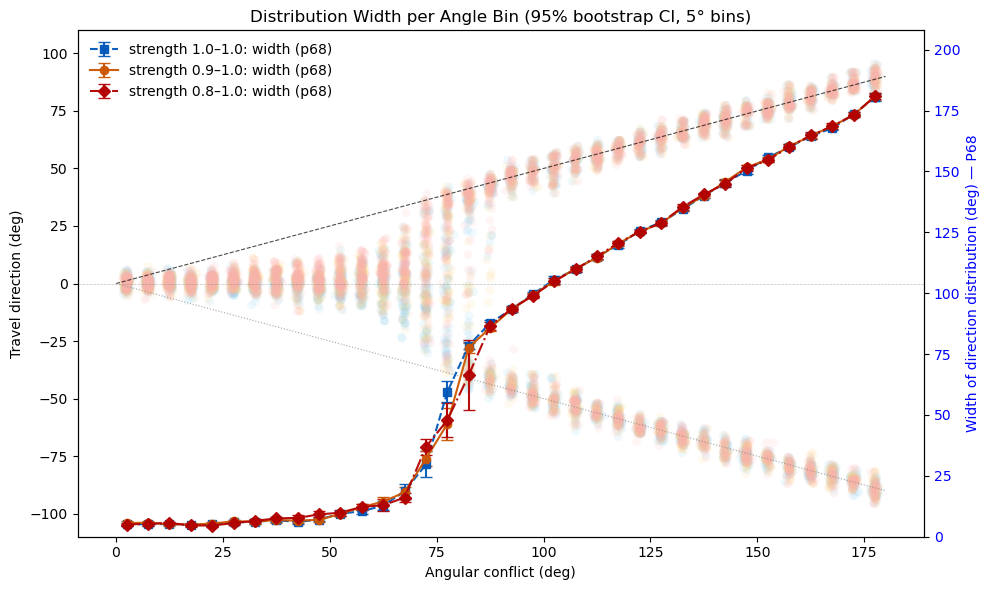

In [30]:
# ==== NEW CONFIG FOR WIDTH ====
WIDTH_METRIC = "p68"   # choose: "std" (sample std), "iqr" (Q75-Q25), "p68" (Q84-Q16), or "p90" (Q95-Q5)
# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}
# ---------- Width estimators ----------
def _width_from_sample(x, metric="std"):
    """Return width (in same units as x) for a given metric."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan
    if metric == "std":
        return float(np.std(x, ddof=1)) if n >= 2 else np.nan
    elif metric == "iqr":
        q25, q75 = np.percentile(x, [25, 75])
        return float(q75 - q25)
    elif metric == "p68":
        q16, q84 = np.percentile(x, [16, 84])
        return float(q84 - q16)
    elif metric == "p90":
        q5, q95 = np.percentile(x, [5, 95])
        return float(q95 - q5)
    else:
        raise ValueError("metric must be one of: 'std', 'iqr', 'p68', 'p90'")

def width_with_ci(x, metric="p68", n_boot=1000, rng_seed=0):
    """
    Return (width_estimate, ci_halfwidth) using bootstrap 95% CI
    for the chosen metric over the distribution of directions (in degrees).
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    # Some metrics need at least 2 points for a meaningful width
    if metric == "std" and n < 2:
        return _width_from_sample(x, metric), np.nan

    rng = np.random.default_rng(rng_seed)
    est = _width_from_sample(x, metric=metric)
    if not np.isfinite(est) or n < 2:
        return float(est), np.nan

    boots = np.empty(N_BOOT, float)
    for i in range(N_BOOT):
        sample = rng.choice(x, size=n, replace=True)
        boots[i] = _width_from_sample(sample, metric=metric)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    ci_half = 0.5 * (hi - lo)
    return float(est), float(ci_half)

# ---------- Per-simulation width in bins (replace binned_order_stat + its uses) ----------
def binned_width_stat(angles_to_dirs, metric, n_boot, seed):
    widths, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            widths.append(np.nan); cis.append(np.nan); continue
        w, ci = width_with_ci(np.array(bin_dirs, float), metric=metric, n_boot=n_boot, rng_seed=seed)
        widths.append(w); cis.append(ci)
    return np.array(widths, float), np.array(cis, float)

# Compute binned widths for each simulation
binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_width_stat(dct, WIDTH_METRIC, N_BOOT, seed=456 + i)

# ---------- Plot (keep your scatter & reference lines; replace the right-axis block/labels/title) ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center) -- unchanged
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis -- unchanged
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: width curves with 95% CI (in degrees)
ax2 = ax1.twinx()
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: width ({WIDTH_METRIC})'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'Width of direction distribution (deg) — {WIDTH_METRIC.upper()}', color='blue')
# A rough auto-limit that works across metrics:
finite_y = np.concatenate([np.asarray(binned[n][0]) for n in binned]).astype(float)
finite_y = finite_y[np.isfinite(finite_y)]
if finite_y.size:
    upper = np.nanmax(finite_y) * 1.15
    ax2.set_ylim(0, max(upper, 5.0))
else:
    ax2.set_ylim(0, 30)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Distribution Width per Angle Bin (95% bootstrap CI, {angle_bin_deg}° bins)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

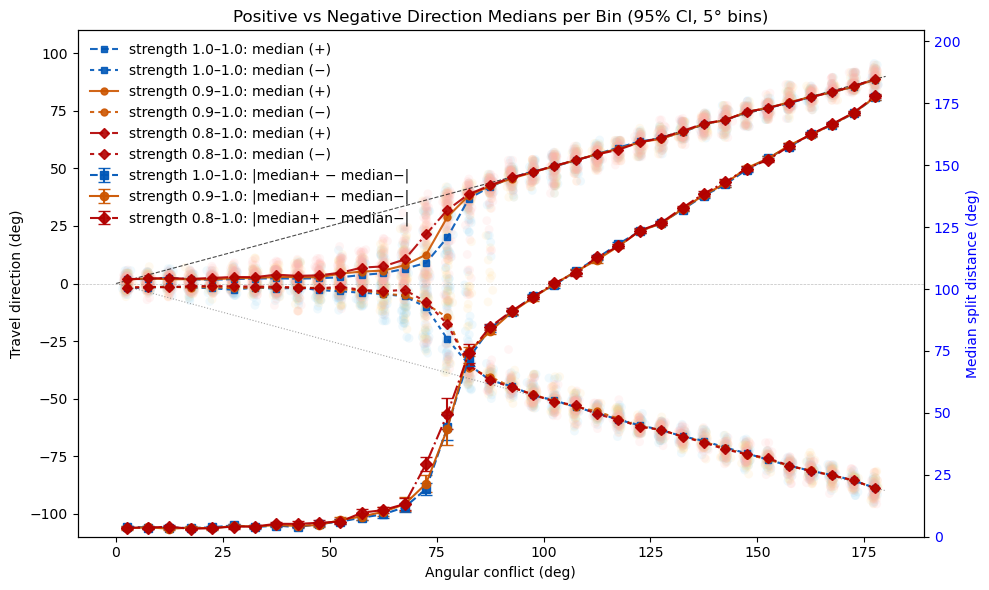

In [25]:
# ==== Median split per bin: positive vs negative directions ====

def _median_split_distance_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Given raw final directions (in degrees), compute:
      - median_pos (x > 0)
      - median_neg (x < 0)
      - dist = |median_pos - median_neg|
      - ci_half: 95% bootstrap half-width for dist
    Returns (median_pos, median_neg, dist, ci_half).
    If one side is empty, returns NaNs.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    pos = x[x > 0]
    neg = x[x < 0]

    if pos.size == 0 or neg.size == 0:
        return np.nan, np.nan, np.nan, np.nan

    med_pos = float(np.median(pos))
    med_neg = float(np.median(neg))
    dist = float(abs(med_pos - med_neg))

    # Bootstrap CI on the distance
    if x.size < 3:
        return med_pos, med_neg, dist, np.nan

    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        sample = rng.choice(x, size=x.size, replace=True)
        s_pos = sample[sample > 0]
        s_neg = sample[sample < 0]
        if s_pos.size == 0 or s_neg.size == 0:
            boots[i] = np.nan
        else:
            boots[i] = abs(np.median(s_pos) - np.median(s_neg))
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):  # too few valid resamples -> unstable CI
        ci_half = np.nan
    else:
        lo, hi = np.percentile(boots, [2.5, 97.5])
        ci_half = 0.5 * (hi - lo)

    return med_pos, med_neg, dist, float(ci_half)

def binned_median_split(angles_to_dirs, n_boot, seed):
    """Per bin, compute (median_pos, median_neg, distance, distance_CI)."""
    mpos, mneg, dists, cis = [], [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            mpos += [np.nan]; mneg += [np.nan]; dists += [np.nan]; cis += [np.nan]
            continue
        mp, mn, dd, ci = _median_split_distance_with_ci(np.array(bin_dirs, float),
                                                        n_boot=n_boot, rng_seed=seed)
        mpos.append(mp); mneg.append(mn); dists.append(dd); cis.append(ci)
    return (np.array(mpos, float), np.array(mneg, float),
            np.array(dists, float), np.array(cis, float))

# Compute per-simulation arrays
split_stats = {}  # name -> (median_pos, median_neg, dist, dist_CI)
for i, (name, dct) in enumerate(sim_data.items()):
    split_stats[name] = binned_median_split(dct, N_BOOT, seed=1234 + i)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Left axis: per-bin medians of positive and negative directions (deg)
for name in sim_data.keys():
    mpos, mneg, _, _ = split_stats[name]
    ax1.plot(bin_centers, mpos, linestyle=style[name]["ls"], marker=style[name]["marker"],
             ms=5, alpha=0.9, color=style[name]["ln"], label=f"{name}: median (+)")
    ax1.plot(bin_centers, mneg, linestyle=style[name]["ls"], marker=style[name]["marker"],
             ms=5, alpha=0.9, color=style[name]["ln"], label=f"{name}: median (−)", dashes=(2,2))

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: distance between medians (deg) with 95% CI
ax2 = ax1.twinx()
for name in sim_data.keys():
    _, _, dist, ci = split_stats[name]
    ax2.errorbar(
        bin_centers, dist, yerr=ci,
        fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f"{name}: |median+ − median−|"
    )
ax2.set_ylabel("Median split distance (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Set sensible y-limit for distance axis
all_d = np.concatenate([split_stats[n][2] for n in split_stats])
all_d = all_d[np.isfinite(all_d)]
ax2.set_ylim(0, max(5.0, np.nanmax(all_d) * 1.15) if all_d.size else 5.0)

plt.title(f"Positive vs Negative Direction Medians per Bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


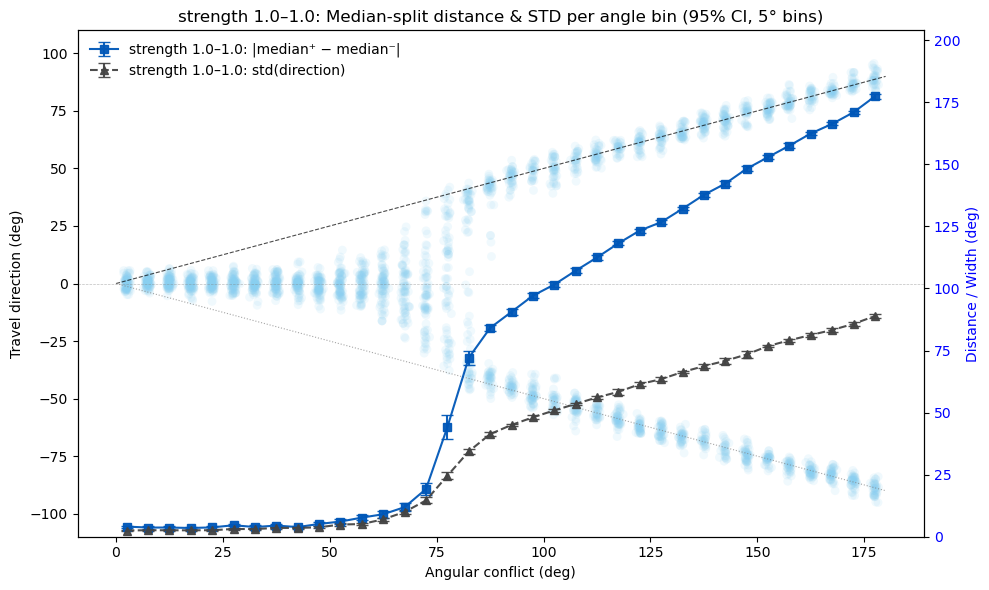

In [27]:
# ==== Focus on one experiment only ====
TARGET = "strength 1.0–1.0"
angles_to_dirs = sim_data[TARGET]

# ---------- Helpers for this figure ----------

def std_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Sample standard deviation (ddof=1) with 95% bootstrap CI.
    Returns (std_est, ci_halfwidth). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    est = float(np.std(x, ddof=1))
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        boots[i] = np.std(s, ddof=1) if s.size >= 2 else np.nan
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return est, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def median_split_distance_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Distance between medians of positive (>0°) and negative (<0°) directions with 95% bootstrap CI.
    Returns (median_pos, median_neg, dist, ci_half). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    pos = x[x > 0]
    neg = x[x < 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan, np.nan, np.nan, np.nan
    med_pos = float(np.median(pos))
    med_neg = float(np.median(neg))
    dist = float(abs(med_pos - med_neg))

    rng = np.random.default_rng(rng_seed)
    if x.size < 3:
        return med_pos, med_neg, dist, np.nan

    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=x.size, replace=True)
        sp, sn = s[s > 0], s[s < 0]
        boots[i] = (abs(np.median(sp) - np.median(sn))
                    if (sp.size and sn.size) else np.nan)
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return med_pos, med_neg, dist, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return med_pos, med_neg, dist, 0.5 * (hi - lo)

def binned_stats(angles_to_dirs, n_boot, seed_base):
    """Per angle bin: return dict with std(+CI) and median-split distance(+CI)."""
    stds, std_cis = [], []
    mpos, mneg, dists, dist_cis = [], [], [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            stds.append(np.nan); std_cis.append(np.nan)
            mpos.append(np.nan); mneg.append(np.nan); dists.append(np.nan); dist_cis.append(np.nan)
            continue
        s_est, s_ci = std_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 10*j)
        mp, mn, dd, dci = median_split_distance_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 20*j)
        stds.append(s_est); std_cis.append(s_ci)
        mpos.append(mp); mneg.append(mn); dists.append(dd); dist_cis.append(dci)
    return {
        "std": np.array(stds, float),
        "std_ci": np.array(std_cis, float),
        "mpos": np.array(mpos, float),
        "mneg": np.array(mneg, float),
        "dist": np.array(dists, float),
        "dist_ci": np.array(dist_cis, float),
    }

stats = binned_stats(angles_to_dirs, N_BOOT, seed_base=777)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter (snapped) for TARGET only
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: both curves (median-split distance and std) with CI
ax2 = ax1.twinx()

# 1) Median-split distance
ax2.errorbar(
    bin_centers, stats["dist"], yerr=stats["dist_ci"],
    fmt=style[TARGET]["marker"] + "-", capsize=4, alpha=0.95,
    color=style[TARGET]["ln"], label=f"{TARGET}: |median⁺ − median⁻|"
)

# 2) Standard deviation (ddof=1)
ax2.errorbar(
    bin_centers, stats["std"], yerr=stats["std_ci"],
    fmt="^--", capsize=4, alpha=0.95,
    color="#444444", label=f"{TARGET}: std(direction)"
)

ax2.set_ylabel("Distance / Width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Sensible y-limit for right axis
vals = np.concatenate([stats["dist"], stats["std"]])
vals = vals[np.isfinite(vals)]
ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)

plt.title(f"{TARGET}: Median-split distance & STD per angle bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


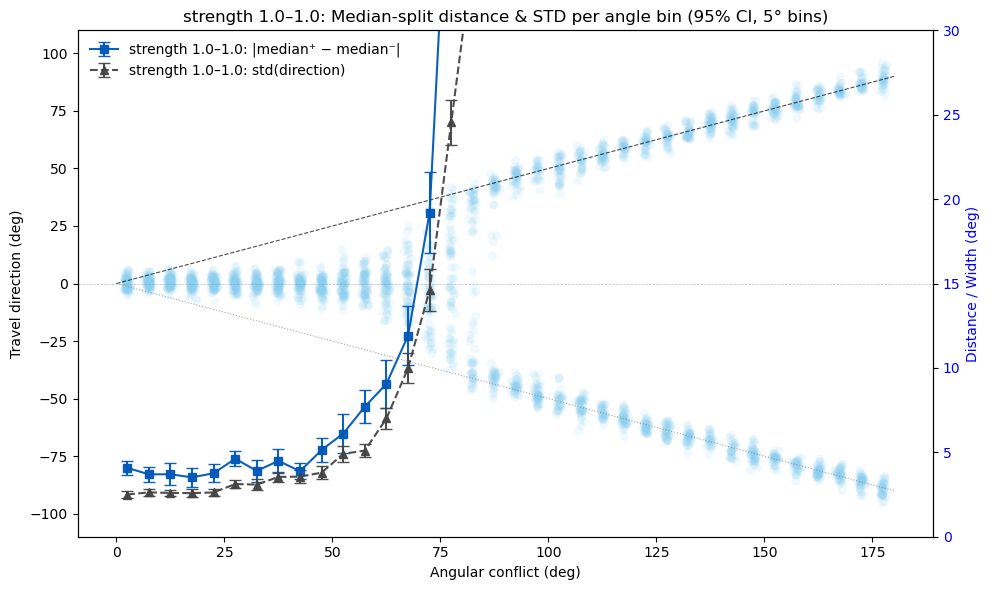

In [32]:
# ==== Focus on one experiment only ====
TARGET = "strength 1.0–1.0"
angles_to_dirs = sim_data[TARGET]

# ---------- Helpers for this figure ----------

def std_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Sample standard deviation (ddof=1) with 95% bootstrap CI.
    Returns (std_est, ci_halfwidth). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    est = float(np.std(x, ddof=1))
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        boots[i] = np.std(s, ddof=1) if s.size >= 2 else np.nan
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return est, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def median_split_distance_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Distance between medians of positive (>0°) and negative (<0°) directions with 95% bootstrap CI.
    Returns (median_pos, median_neg, dist, ci_half). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    pos = x[x > 0]
    neg = x[x < 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan, np.nan, np.nan, np.nan
    med_pos = float(np.median(pos))
    med_neg = float(np.median(neg))
    dist = float(abs(med_pos - med_neg))

    rng = np.random.default_rng(rng_seed)
    if x.size < 3:
        return med_pos, med_neg, dist, np.nan

    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=x.size, replace=True)
        sp, sn = s[s > 0], s[s < 0]
        boots[i] = (abs(np.median(sp) - np.median(sn))
                    if (sp.size and sn.size) else np.nan)
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return med_pos, med_neg, dist, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return med_pos, med_neg, dist, 0.5 * (hi - lo)

def binned_stats(angles_to_dirs, n_boot, seed_base):
    """Per angle bin: return dict with std(+CI) and median-split distance(+CI)."""
    stds, std_cis = [], []
    mpos, mneg, dists, dist_cis = [], [], [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            stds.append(np.nan); std_cis.append(np.nan)
            mpos.append(np.nan); mneg.append(np.nan); dists.append(np.nan); dist_cis.append(np.nan)
            continue
        s_est, s_ci = std_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 10*j)
        mp, mn, dd, dci = median_split_distance_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 20*j)
        stds.append(s_est); std_cis.append(s_ci)
        mpos.append(mp); mneg.append(mn); dists.append(dd); dist_cis.append(dci)
    return {
        "std": np.array(stds, float),
        "std_ci": np.array(std_cis, float),
        "mpos": np.array(mpos, float),
        "mneg": np.array(mneg, float),
        "dist": np.array(dists, float),
        "dist_ci": np.array(dist_cis, float),
    }

stats = binned_stats(angles_to_dirs, N_BOOT, seed_base=777)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter (snapped) for TARGET only
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: both curves (median-split distance and std) with CI
ax2 = ax1.twinx()

# 1) Median-split distance
ax2.errorbar(
    bin_centers, stats["dist"], yerr=stats["dist_ci"],
    fmt=style[TARGET]["marker"] + "-", capsize=4, alpha=0.95,
    color=style[TARGET]["ln"], label=f"{TARGET}: |median⁺ − median⁻|"
)

# 2) Standard deviation (ddof=1)
ax2.errorbar(
    bin_centers, stats["std"], yerr=stats["std_ci"],
    fmt="^--", capsize=4, alpha=0.95,
    color="#444444", label=f"{TARGET}: std(direction)"
)

ax2.set_ylabel("Distance / Width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Sensible y-limit for right axis
vals = np.concatenate([stats["dist"], stats["std"]])
vals = vals[np.isfinite(vals)]
#ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)
ax2.set_ylim(0, 30)

plt.title(f"{TARGET}: Median-split distance & STD per angle bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


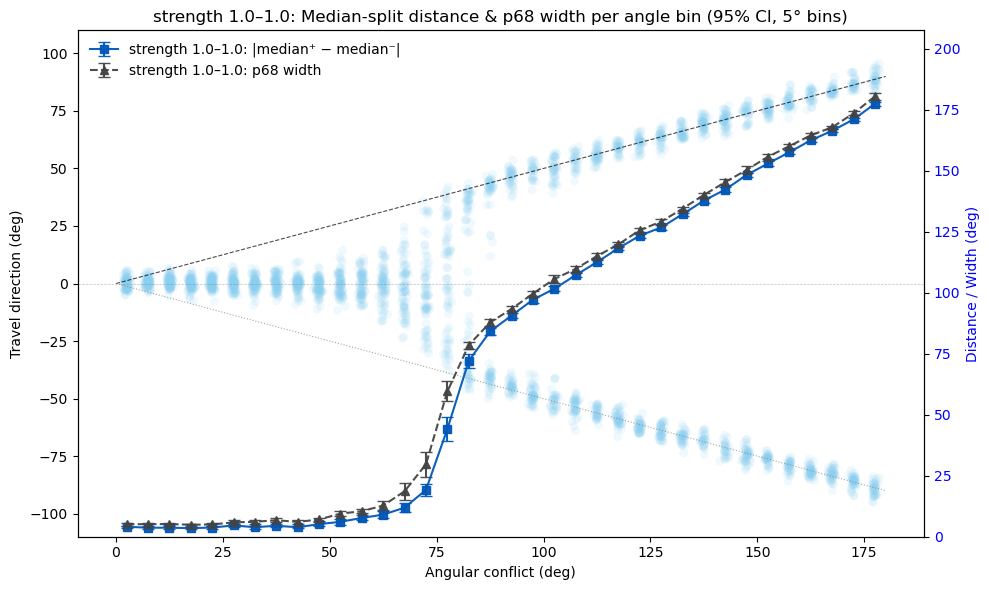

In [29]:
# ==== Focus on one experiment only ====
TARGET = "strength 1.0–1.0"
angles_to_dirs = sim_data[TARGET]

# ---------- Helpers (p68 width + median-split distance) ----------

def p68_width_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    p68 width = Q84 - Q16, with 95% bootstrap CI.
    Returns (est, ci_halfwidth). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan

    q16, q84 = np.percentile(x, [16, 84])
    est = float(q84 - q16)

    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        q16, q84 = np.percentile(s, [16, 84])
        boots[i] = q84 - q16
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def median_split_distance_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Distance between medians of positive (>0°) and negative (<0°) directions,
    with 95% bootstrap CI.
    Returns (median_pos, median_neg, dist, ci_half). Units: degrees.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    pos = x[x > 0]
    neg = x[x < 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan, np.nan, np.nan, np.nan

    med_pos = float(np.median(pos))
    med_neg = float(np.median(neg))
    dist = float(abs(med_pos - med_neg))

    rng = np.random.default_rng(rng_seed)
    if x.size < 3:
        return med_pos, med_neg, dist, np.nan

    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=x.size, replace=True)
        sp, sn = s[s > 0], s[s < 0]
        if sp.size and sn.size:
            boots[i] = abs(np.median(sp) - np.median(sn))
        else:
            boots[i] = np.nan
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return med_pos, med_neg, dist, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return med_pos, med_neg, dist, 0.5 * (hi - lo)

def binned_stats_p68_median(angles_to_dirs, n_boot, seed_base):
    """Per angle bin: return dict with p68 width(+CI) and median-split distance(+CI)."""
    widths, width_cis = [], []
    mpos, mneg, dists, dist_cis = [], [], [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            widths.append(np.nan); width_cis.append(np.nan)
            mpos.append(np.nan); mneg.append(np.nan); dists.append(np.nan); dist_cis.append(np.nan)
            continue
        w_est, w_ci = p68_width_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 10*j)
        mp, mn, dd, dci = median_split_distance_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 20*j)
        widths.append(w_est); width_cis.append(w_ci)
        mpos.append(mp); mneg.append(mn); dists.append(dd); dist_cis.append(dci)
    return {
        "p68": np.array(widths, float),
        "p68_ci": np.array(width_cis, float),
        "mpos": np.array(mpos, float),
        "mneg": np.array(mn, float),
        "dist": np.array(dists, float),
        "dist_ci": np.array(dist_cis, float),
    }

stats = binned_stats_p68_median(angles_to_dirs, N_BOOT, seed_base=2718)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter (snapped) for TARGET only
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: both curves (median-split distance and p68 width) with CI
ax2 = ax1.twinx()

# 1) Median-split distance
ax2.errorbar(
    bin_centers, stats["dist"], yerr=stats["dist_ci"],
    fmt=style[TARGET]["marker"] + "-", capsize=4, alpha=0.95,
    color=style[TARGET]["ln"], label=f"{TARGET}: |median⁺ − median⁻|"
)

# 2) p68 width
ax2.errorbar(
    bin_centers, stats["p68"], yerr=stats["p68_ci"],
    fmt="^--", capsize=4, alpha=0.95,
    color="#444444", label=f"{TARGET}: p68 width"
)

ax2.set_ylabel("Distance / Width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Sensible y-limit for right axis
vals = np.concatenate([stats["dist"], stats["p68"]])
vals = vals[np.isfinite(vals)]
ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)

plt.title(f"{TARGET}: Median-split distance & p68 width per angle bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


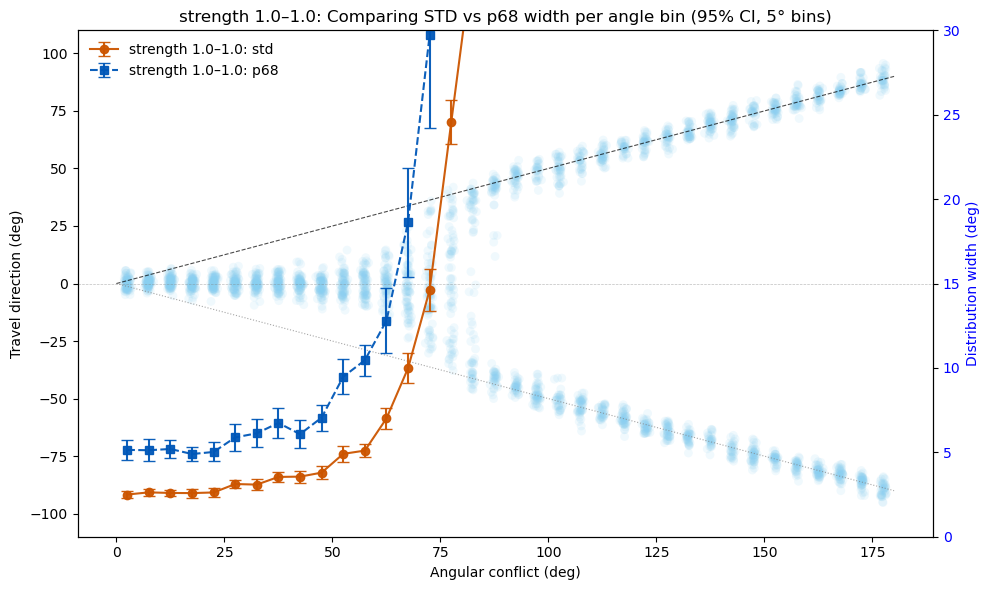

In [34]:
# ==== Focus on one experiment only ====
TARGET = "strength 1.0–1.0"
angles_to_dirs = sim_data[TARGET]

# ---------- Helpers (p68 and std) ----------

def std_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Sample standard deviation (ddof=1) with 95% bootstrap CI.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    est = float(np.std(x, ddof=1))
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        boots[i] = np.std(s, ddof=1) if s.size >= 2 else np.nan
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return est, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def p68_width_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    p68 width = Q84 - Q16, with 95% bootstrap CI.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    q16, q84 = np.percentile(x, [16, 84])
    est = float(q84 - q16)
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        q16, q84 = np.percentile(s, [16, 84])
        boots[i] = q84 - q16
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def binned_stats_widths(angles_to_dirs, n_boot, seed_base):
    """Per angle bin: return dict with std(+CI) and p68(+CI)."""
    stds, std_cis, p68s, p68_cis = [], [], [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            stds.append(np.nan); std_cis.append(np.nan)
            p68s.append(np.nan); p68_cis.append(np.nan)
            continue
        s_est, s_ci = std_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 10*j)
        w_est, w_ci = p68_width_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 20*j)
        stds.append(s_est); std_cis.append(s_ci)
        p68s.append(w_est); p68_cis.append(w_ci)
    return {
        "std": np.array(stds, float),
        "std_ci": np.array(std_cis, float),
        "p68": np.array(p68s, float),
        "p68_ci": np.array(p68_cis, float),
    }

stats = binned_stats_widths(angles_to_dirs, N_BOOT, seed_base=10101)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter (snapped) for context
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: p68 vs std
ax2 = ax1.twinx()

# STD curve
ax2.errorbar(
    bin_centers, stats["std"], yerr=stats["std_ci"],
    fmt="o-", capsize=4, alpha=0.95,
    color="#CC5500", label=f"{TARGET}: std"
)

# p68 curve
ax2.errorbar(
    bin_centers, stats["p68"], yerr=stats["p68_ci"],
    fmt="s--", capsize=4, alpha=0.95,
    color="#0057B8", label=f"{TARGET}: p68"
)

ax2.set_ylabel("Distribution width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Set y-limit
vals = np.concatenate([stats["std"], stats["p68"]])
vals = vals[np.isfinite(vals)]
ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)
ax2.set_ylim(0, 30)

plt.title(f"{TARGET}: Comparing STD vs p68 width per angle bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


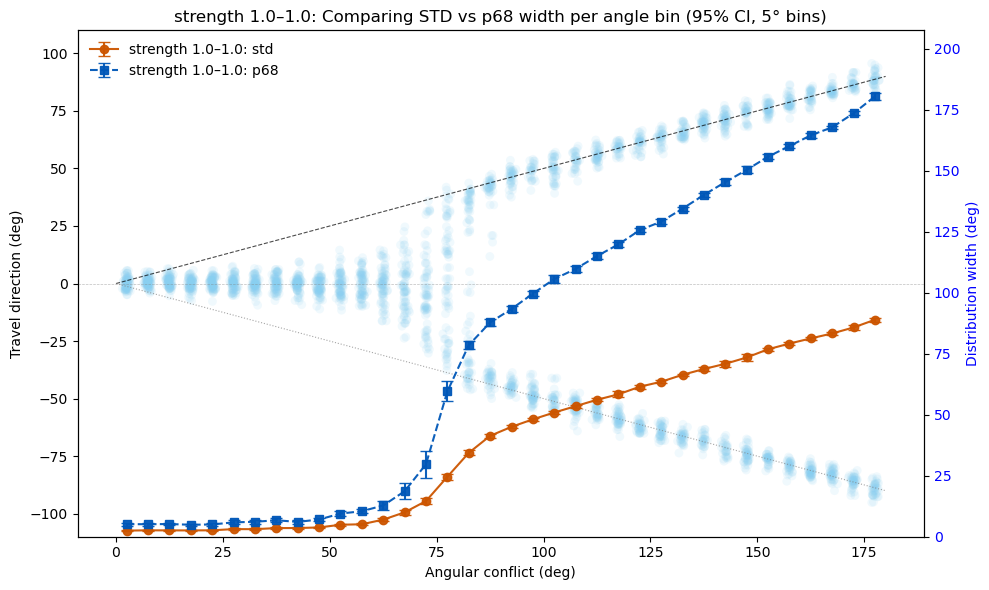

In [35]:
# ==== Focus on one experiment only ====
TARGET = "strength 1.0–1.0"
angles_to_dirs = sim_data[TARGET]

# ---------- Helpers (p68 and std) ----------

def std_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Sample standard deviation (ddof=1) with 95% bootstrap CI.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    est = float(np.std(x, ddof=1))
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        boots[i] = np.std(s, ddof=1) if s.size >= 2 else np.nan
    boots = boots[np.isfinite(boots)]
    if boots.size < max(10, n_boot // 10):
        return est, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def p68_width_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    p68 width = Q84 - Q16, with 95% bootstrap CI.
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    q16, q84 = np.percentile(x, [16, 84])
    est = float(q84 - q16)
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    for i in range(n_boot):
        s = rng.choice(x, size=n, replace=True)
        q16, q84 = np.percentile(s, [16, 84])
        boots[i] = q84 - q16
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def binned_stats_widths(angles_to_dirs, n_boot, seed_base):
    """Per angle bin: return dict with std(+CI) and p68(+CI)."""
    stds, std_cis, p68s, p68_cis = [], [], [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            stds.append(np.nan); std_cis.append(np.nan)
            p68s.append(np.nan); p68_cis.append(np.nan)
            continue
        s_est, s_ci = std_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 10*j)
        w_est, w_ci = p68_width_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 20*j)
        stds.append(s_est); std_cis.append(s_ci)
        p68s.append(w_est); p68_cis.append(w_ci)
    return {
        "std": np.array(stds, float),
        "std_ci": np.array(std_cis, float),
        "p68": np.array(p68s, float),
        "p68_ci": np.array(p68_cis, float),
    }

stats = binned_stats_widths(angles_to_dirs, N_BOOT, seed_base=10101)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter (snapped) for context
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis: p68 vs std
ax2 = ax1.twinx()

# STD curve
ax2.errorbar(
    bin_centers, stats["std"], yerr=stats["std_ci"],
    fmt="o-", capsize=4, alpha=0.95,
    color="#CC5500", label=f"{TARGET}: std"
)

# p68 curve
ax2.errorbar(
    bin_centers, stats["p68"], yerr=stats["p68_ci"],
    fmt="s--", capsize=4, alpha=0.95,
    color="#0057B8", label=f"{TARGET}: p68"
)

ax2.set_ylabel("Distribution width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Set y-limit
vals = np.concatenate([stats["std"], stats["p68"]])
vals = vals[np.isfinite(vals)]
ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)

plt.title(f"{TARGET}: Comparing STD vs p68 width per angle bin (95% CI, {angle_bin_deg}° bins)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


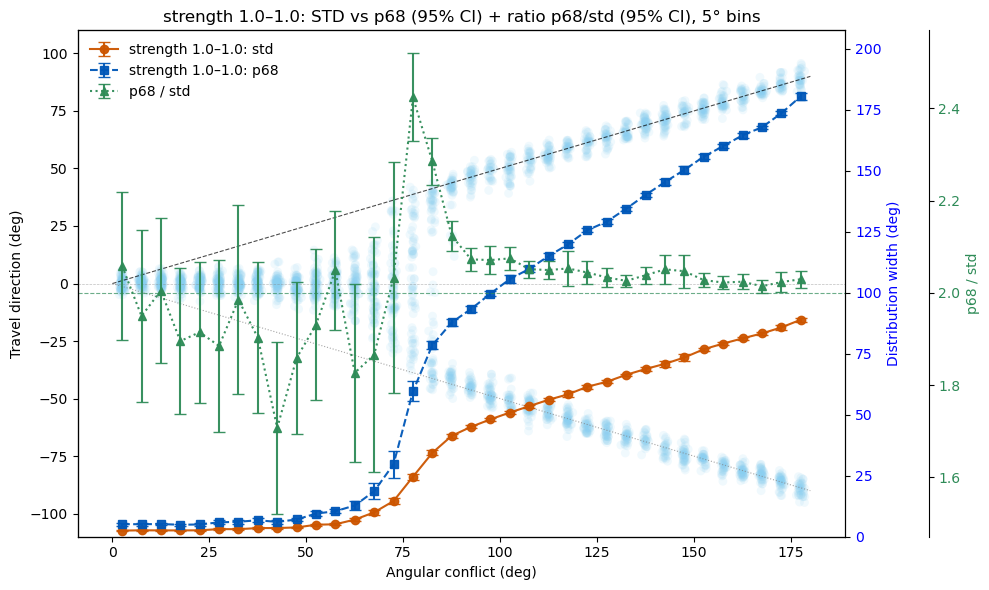

In [36]:
# ---------- Add: ratio p68/std with bootstrap CI ----------
def ratio_p68_over_std_with_ci(x_deg, n_boot=1000, rng_seed=0):
    """
    Returns (ratio_est, ci_half) for ratio = p68 / std (ddof=1).
    Uses bootstrap on the *ratio* directly.
    If std==0 or degenerate samples, returns (nan, nan).
    """
    x = np.asarray(x_deg, float)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.nan, np.nan

    # point estimates
    q16, q84 = np.percentile(x, [16, 84])
    p68 = float(q84 - q16)
    sd  = float(np.std(x, ddof=1))
    if not np.isfinite(p68) or not np.isfinite(sd) or sd <= 0:
        return np.nan, np.nan
    est = p68 / sd

    # bootstrap
    rng = np.random.default_rng(rng_seed)
    boots = np.empty(n_boot, float)
    k = 0
    for i in range(n_boot):
        s = rng.choice(x, size=x.size, replace=True)
        if s.size < 2:
            continue
        q16b, q84b = np.percentile(s, [16, 84])
        p68b = q84b - q16b
        sdb  = np.std(s, ddof=1)
        if np.isfinite(p68b) and np.isfinite(sdb) and sdb > 0:
            boots[k] = p68b / sdb
            k += 1
    if k < max(10, n_boot // 10):
        return est, np.nan
    boots = boots[:k]
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return est, 0.5 * (hi - lo)

def binned_ratio(angles_to_dirs, n_boot, seed_base):
    ratios, ratio_cis = [], []
    for j, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        bin_dirs = []
        for a, ds in angles_to_dirs.items():
            if lo <= a < hi:
                bin_dirs.extend(ds)
        if not bin_dirs:
            ratios.append(np.nan); ratio_cis.append(np.nan); continue
        r, rci = ratio_p68_over_std_with_ci(bin_dirs, n_boot=n_boot, rng_seed=seed_base + 30*j)
        ratios.append(r); ratio_cis.append(rci)
    return np.array(ratios, float), np.array(ratio_cis, float)

ratio_vals, ratio_cis = binned_ratio(angles_to_dirs, N_BOOT, seed_base=2025)

# ---------- Plot: keep widths on ax2, add ratio on a second right axis ax3 ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left-axis scatter for context
xa, ya = snapped_scatter[TARGET]
if xa.size:
    ax1.scatter(
        jitter(xa), ya, s=40, alpha=0.12, color=style[TARGET]["pt"],
        edgecolors="none", label=None
    )

# Reference lines on left axis
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

# Right axis for widths
ax2 = ax1.twinx()
e1 = ax2.errorbar(
    bin_centers, stats["std"], yerr=stats["std_ci"],
    fmt="o-", capsize=4, alpha=0.95, color="#CC5500", label=f"{TARGET}: std"
)
e2 = ax2.errorbar(
    bin_centers, stats["p68"], yerr=stats["p68_ci"],
    fmt="s--", capsize=4, alpha=0.95, color="#0057B8", label=f"{TARGET}: p68"
)
ax2.set_ylabel("Distribution width (deg)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
vals = np.concatenate([stats["std"], stats["p68"]])
vals = vals[np.isfinite(vals)]
ax2.set_ylim(0, max(5.0, np.nanmax(vals) * 1.15) if vals.size else 5.0)

# Second right axis, offset outward, for ratio
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
e3 = ax3.errorbar(
    bin_centers, ratio_vals, yerr=ratio_cis,
    fmt="^:", capsize=4, alpha=0.95, color="#2E8B57", label="p68 / std"
)
ax3.set_ylabel("p68 / std", color="#2E8B57")
ax3.tick_params(axis='y', labelcolor="#2E8B57")

# Reference line for Gaussian case (≈2.0)
ax3.axhline(2.0, linestyle="--", linewidth=0.8, color="#2E8B57", alpha=0.7)

plt.title(f"{TARGET}: STD vs p68 (95% CI) + ratio p68/std (95% CI), {angle_bin_deg}° bins")

# Build combined legend (handles from all axes)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
ax1.legend(h1 + h2 + h3, l1 + l2 + l3, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()


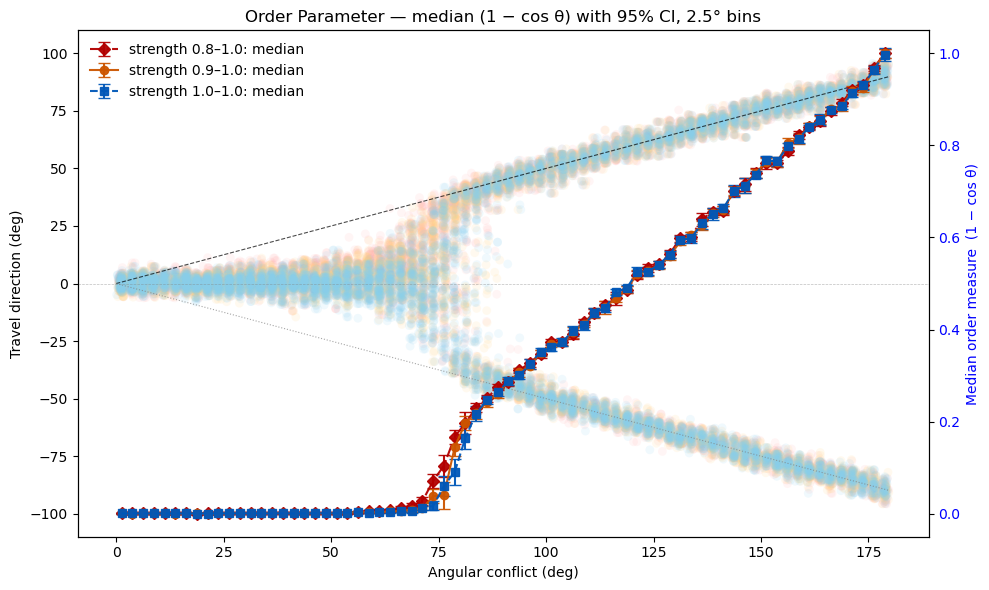

In [5]:
# --- COMPARISON PLOT: Simulations (configurable 10° bins)
# --- Order parameter: mean/median/mode of 1 - cos(direction) with 95% bootstrap CI ---

import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun",
}
h5_name = "experiment.h5"

angle_bin_deg = 2.5     # bin width for simulations (set to 10° bins as requested)
snap_tol_deg = 0.75    # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "median"  # choose: "mean", "median", or "mode"
ORDER_MEASURE = "1-cos"  # choose: "1-cos" (this script default) or "abs-sin"
N_BOOT = 1000          # bootstrap samples for CI

# Colors (points + lines) per simulation
style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2", "ln": "#B20000", "marker": "D", "ls": "-."},
    "strength 1.0–1.0": {"pt": "#89CFF0", "ln": "#0057B8", "marker": "s", "ls": "--"},
    "strength 0.9–1.0": {"pt": "#FFD580", "ln": "#CC5500", "marker": "o", "ls": "-"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def order_measure_deg(direction_deg_array, measure="1-cos"):
    """
    Compute a scalar order measure from directions (deg).
    - "1-cos": returns 1 - cos(theta) in [0, 2]
    - "abs-sin": returns |sin(theta)| in [0, 1]
    """
    theta_rad = np.radians(np.asarray(direction_deg_array, float))
    if measure == "1-cos":
        return 1.0 - np.cos(theta_rad)
    elif measure == "abs-sin":
        return np.abs(np.sin(theta_rad))
    else:
        raise ValueError("measure must be '1-cos' or 'abs-sin'")

def _mode_hist(x, bins="fd", value_range=(0.0, 1.0)):
    """Histogram-mode estimator over a specified value_range."""
    x = np.asarray(x, float)
    if x.size == 0 or not np.isfinite(x).any():
        return np.nan
    x = x[np.isfinite(x)]
    if isinstance(bins, str) and bins == "fd":
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        bins = max(5, int(np.ceil((x.max() - x.min()) / h))) if h > 0 else 10
    counts, edges = np.histogram(x, bins=bins, range=value_range)
    if counts.sum() == 0:
        return np.nan
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0, value_range=(0.0, 1.0)):
    """
    Return (estimate, ci_halfwidth) for stat in {'mean','median','mode'} using bootstrap 95% CI.
    When stat == 'mode', a histogram mode within value_range is used.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan

    rng = np.random.default_rng(rng_seed)

    if stat == "mean":
        est = float(np.mean(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            boots[i] = np.mean(rng.choice(x, size=n, replace=True))
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "median":
        est = float(np.median(x))
        if n < 2:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            boots[i] = np.median(rng.choice(x, size=n, replace=True))
        lo, hi = np.percentile(boots, [2.5, 97.5])

    elif stat == "mode":
        est = float(_mode_hist(x, value_range=value_range))
        if n < 3:
            return est, np.nan
        boots = np.empty(n_boot, float)
        for i in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots[i] = _mode_hist(sample, value_range=value_range)
        lo, hi = np.percentile(boots, [2.5, 97.5])

    else:
        raise ValueError("stat must be 'mean', 'median', or 'mode'")

    ci_half = 0.5 * (hi - lo)
    return est, float(ci_half)

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    if not os.path.exists(h5_path):
        raise FileNotFoundError(f"Missing HDF5 file: {h5_path}")
    out = {}
    with h5py.File(h5_path, "r") as f:
        if "runs" not in f:
            raise ValueError(f"'runs' group not found in {h5_path}")
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}  # name -> dict(angle->list[dir_deg])
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Shared binning over the combined angle range ----------
all_angles = np.array([a for d in sim_data.values() for a in d.keys()], float)
angle_min = max(0, np.floor(all_angles.min()))
angle_max = min(180, np.ceil(all_angles.max()))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# ---------- Per-simulation order stat in bins ----------
value_range = (0.0, 2.0) if ORDER_MEASURE == "1-cos" else (0.0, 1.0)

def binned_order_stat(angles_to_dirs, stat, n_boot, seed, measure, value_range):
    stats, cis = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        bin_dirs = []
        for angle_val, dirs in angles_to_dirs.items():
            if lo <= angle_val < hi:
                bin_dirs.extend(dirs)
        if not bin_dirs:
            stats.append(np.nan); cis.append(np.nan); continue
        vals = order_measure_deg(np.array(bin_dirs, dtype=float), measure=measure)
        est, ci = order_stat_with_ci(vals, stat=stat, n_boot=n_boot, rng_seed=seed, value_range=value_range)
        stats.append(est); cis.append(ci)
    return np.array(stats, float), np.array(cis, float)

binned = {}
for i, (name, dct) in enumerate(sim_data.items()):
    binned[name] = binned_order_stat(dct, ORDER_STAT, N_BOOT, seed=456 + i,
                                     measure=ORDER_MEASURE, value_range=value_range)

# ---------- Prepare snapped scatter for raw directions ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

snapped_scatter = {}  # name -> (angles_snapped, dirs)
bcent = np.array(bin_centers)
for name, dct in sim_data.items():
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        nearest_bin = bcent[np.argmin(np.abs(bcent - a))]
        if abs(nearest_bin - a) <= snap_tol_deg:
            angles_all.extend([nearest_bin] * len(vals))
            dirs_all.extend(vals)
    snapped_scatter[name] = (np.array(angles_all, float), np.array(dirs_all, float))

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter of raw final directions (snapped to nearest bin center)
for name in sim_data.keys():
    xa, ya = snapped_scatter[name]
    if xa.size:
        ax1.scatter(
            jitter(xa), ya, s=40, alpha=0.12, color=style[name]["pt"],
            edgecolors="none", label=None
        )

# Reference lines on direction axis (left)
x_line = np.linspace(edges[0], edges[-1], 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Right axis: order-stat curves with 95% CI
ax2 = ax1.twinx()
for name in sim_data.keys():
    y, ci = binned[name]
    ax2.errorbar(
        bin_centers, y, yerr=ci, fmt=style[name]["marker"] + style[name]["ls"],
        capsize=4, alpha=0.95, color=style[name]["ln"],
        label=f'{name}: {ORDER_STAT}'
    )

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)")
ax1.set_ylim(-110, 110)

ylabel = (f'{ORDER_STAT.capitalize()} order measure  (1 − cos θ)'
          if ORDER_MEASURE == "1-cos"
          else f'{ORDER_STAT.capitalize()} normal component  |sin(θ)|')
ax2.set_ylabel(ylabel, color='blue')
ax2.set_ylim(-0.05, 1.05 if ORDER_MEASURE == "1-cos" else 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(
    f'Order Parameter — {ORDER_STAT} '
    + ('(1 − cos θ)' if ORDER_MEASURE == "1-cos" else 'normal component (|sin θ|)')
    + f' with 95% CI, {angle_bin_deg}° bins'
)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False, ncols=1)

fig.tight_layout()
plt.show()
